In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Convergence Integrity: We use the `SARIMAX` state-space engine instead of the standard `ARIMA` class to ensure stable convergence on small datasets. This avoids the `ConvergenceWarning` often found in MLE optimization for mortality data.

PACF Estimation: The `method='ywm'` (Unadjusted Yule-Walker) is explicitly set in PACF plots to ensure correlation values remain within the valid [-1, 1] range, preventing `FutureWarning`.


Stationarity: The model is fitted as a Random Walk with Drift ($d=1$ with constant trend) on log-transformed data.

In [2]:
df = pd.read_csv('adult_mortality_indonesia.csv')
df.head()

,year,female,male
0,1990,185.624,234.896
1,1991,183.488,229.230
2,1992,179.502,224.371
3,1993,170.382,216.580
4,1994,174.249,215.981


In [3]:
forecast_steps = 10
split_year = 2017
df['log_male'] = np.log(df['male'])
df['log_female'] = np.log(df['female'])
genders = ['male', 'female']
all_results = {}

# Model Estimation and Performance Validation


 ANALYZING: MALE
                               SARIMAX Results                                
Dep. Variable:               log_male   No. Observations:                   28
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  60.532
Date:                Mon, 29 Dec 2025   AIC                           -117.063
Time:                        19:52:46   BIC                           -114.472
Sample:                             0   HQIC                          -116.293
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0059      0.005     -1.188      0.235      -0.016       0.004
sigma2         0.0007    8.7e-05      7.600      0.000       0.000       0.001
Ljung-Box (L1) (Q):               

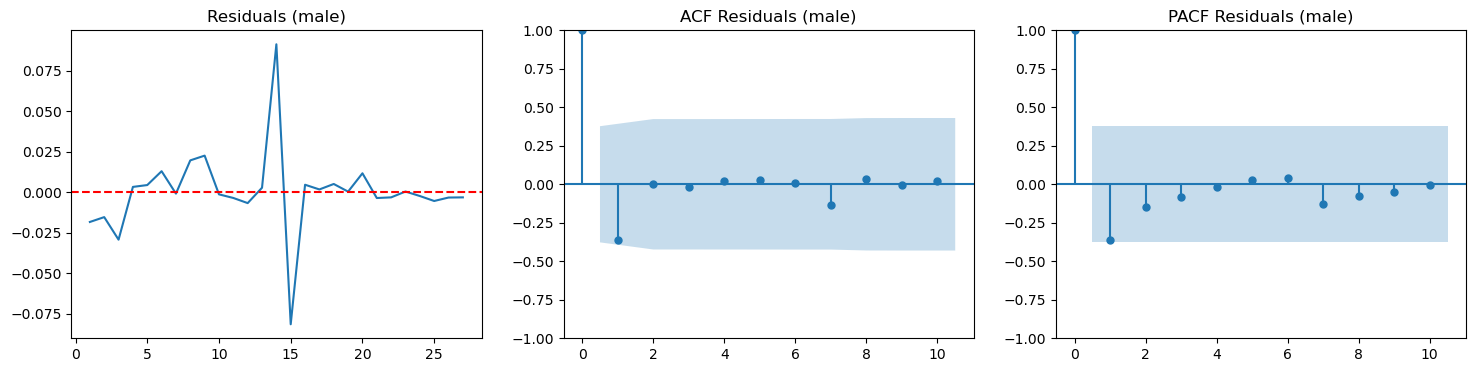

Validation MAPE: 6.20%

 ANALYZING: FEMALE
                               SARIMAX Results                                
Dep. Variable:             log_female   No. Observations:                   28
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  46.297
Date:                Mon, 29 Dec 2025   AIC                            -88.593
Time:                        19:52:46   BIC                            -86.001
Sample:                             0   HQIC                           -87.822
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0077      0.008     -0.913      0.361      -0.024       0.009
sigma2         0.0019      0.000      8.129      0.000       0.001       0.002
Ljung-Box

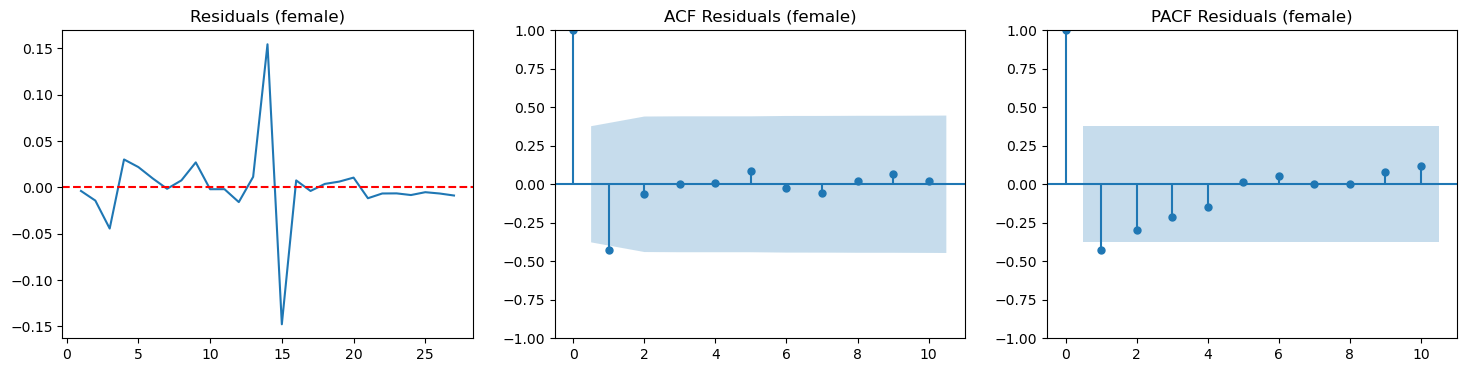

Validation MAPE: 6.90%


C:\Users\fatah\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [4]:
for g in genders:
    print(f"\n{'='*30}")
    print(f" ANALYZING: {g.upper()}")
    print(f"{'='*30}")
    
    col = f'log_{g}'
    train = df[df['year'] <= split_year].copy()
    test = df[df['year'] > split_year].copy()

    model = SARIMAX(train[col], order=(0, 1, 0), trend='c')
    fit_res = model.fit(disp=False) 
    print(fit_res.summary())

    resid = fit_res.resid[1:]
    lb_df = acorr_ljungbox(resid, lags=[5], return_df=True)
    print("\nLjung-Box Test (White Noise Check):")
    print(lb_df)

    fig, ax = plt.subplots(1, 3, figsize=(18, 4))

    ax[0].plot(resid)
    ax[0].set_title(f'Residuals ({g})')
    ax[0].axhline(0, color='red', linestyle='--')

    plot_acf(resid, ax=ax[1], lags=10)
    ax[1].set_title(f'ACF Residuals ({g})')

    plot_pacf(resid, ax=ax[2], lags=10, method='ywm') 
    ax[2].set_title(f'PACF Residuals ({g})')
    plt.show()

    fc_test_obj = fit_res.get_forecast(steps=len(test))
    fc_test_val = np.exp(fc_test_obj.predicted_mean)
    
    mae = mean_absolute_error(test[g], fc_test_val)
    mape = np.mean(np.abs((test[g] - fc_test_val) / test[g])) * 100
    print(f"Validation MAPE: {mape:.2f}%")

    final_model = SARIMAX(df[col], order=(0, 1, 0), trend='c').fit(disp=False)
    fc_future_obj = final_model.get_forecast(steps=forecast_steps)
    
    all_results[g] = {
        'test_actual': test[g],
        'test_pred': fc_test_val,
        'future_pred': np.exp(fc_future_obj.predicted_mean),
        'future_ci': fc_future_obj.conf_int(alpha=0.05),
        'mape': mape
    }

# Final Visualization

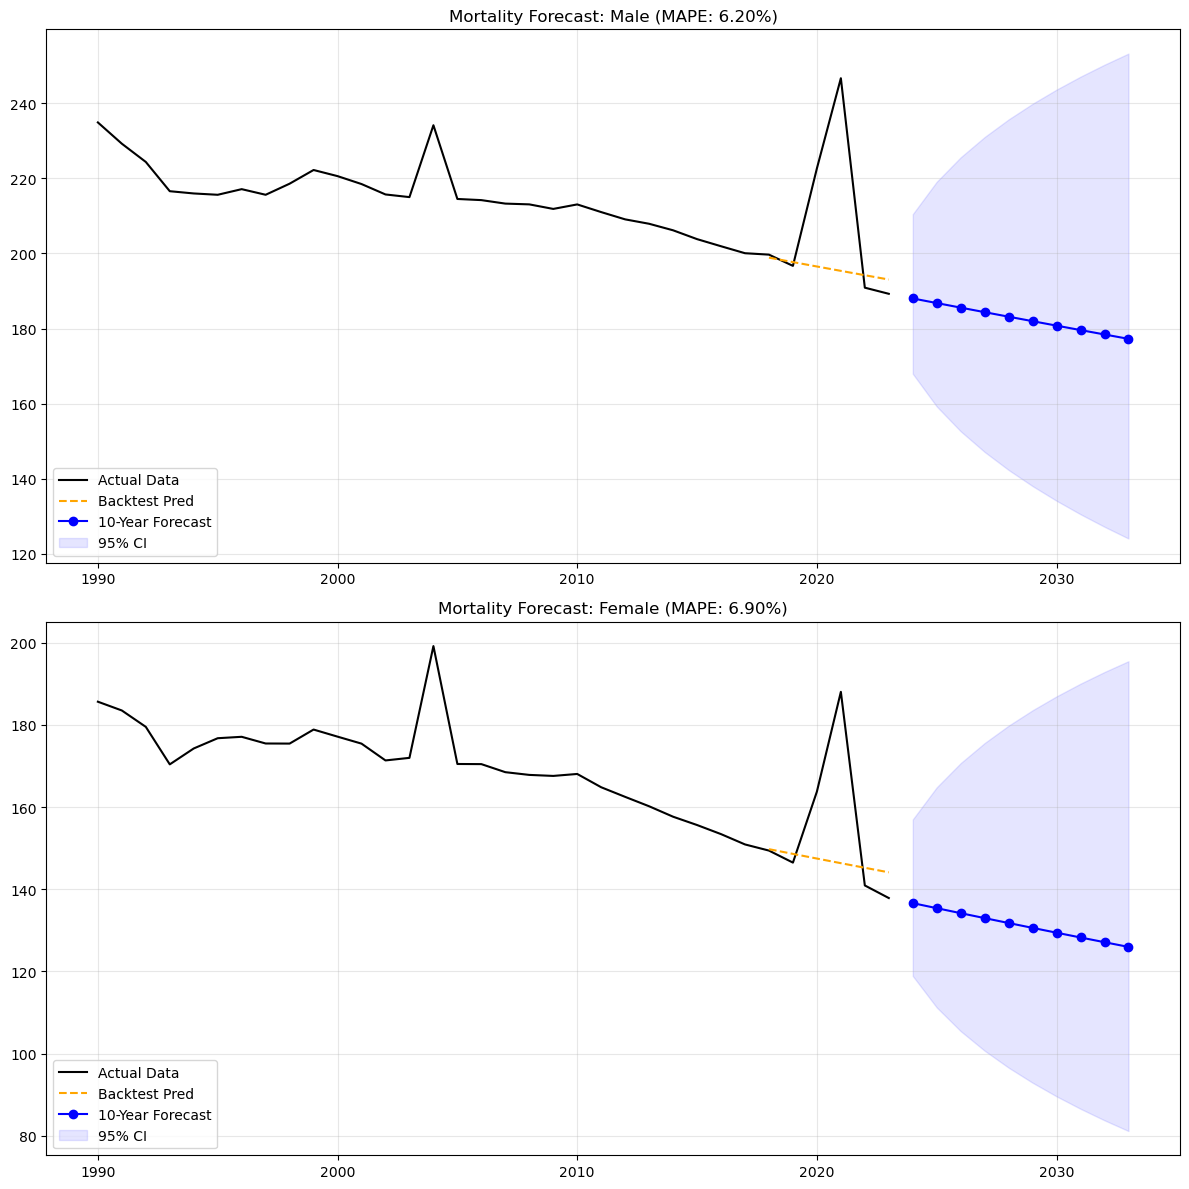

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
future_years = np.arange(df['year'].max() + 1, df['year'].max() + 1 + forecast_steps)

for i, g in enumerate(genders):
    res = all_results[g]
    ax = axes[i]
    
    ax.plot(df['year'], df[g], label='Actual Data', color='black', linewidth=1.5)
    ax.plot(df[df['year'] > split_year]['year'], res['test_pred'], 
            label='Backtest Pred', color='orange', linestyle='--')
    ax.plot(future_years, res['future_pred'], label='10-Year Forecast', color='blue', marker='o')

    lower = np.exp(res['future_ci'].iloc[:, 0])
    upper = np.exp(res['future_ci'].iloc[:, 1])
    ax.fill_between(future_years, lower, upper, color='blue', alpha=0.1, label='95% CI')
    
    ax.set_title(f"Mortality Forecast: {g.capitalize()} (MAPE: {res['mape']:.2f}%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Forecasts should be interpreted as baseline trajectories rather than precise predictions.